## School project - 5DEEP
The following notebook has been created for a school project on audio classification. The subject and the questions are available in the appendix.

The group members who participated in this project are:
- AMIMI Lamine
- BEZIN Théo
- LECOMTE Alexis
- PAWLOWSKI Maxence

### Main index
1. Data analysis
2. Data preprocessing
3. **Basic ANN model (you are here)**
4. The CNN model
5. The model competition
6. Data augmentation
7. _Appendix_

# 3 - Basic ANN model
Now that the dataset is converted into an array of Mel spectrograms, we can begin training our model with a simple Artificial Neural Network (ANN). ANNs are inspired by the biological neural networks that make up animal brains. These neurons are aggregated in layers, each of them performing different transformations on their inputs. Signals (the data) travel from the first layer (the input layer), to the last layer (the output layer), possibly after traversing the layers multiple times.

### Index
<ol type="A">
  <li>Notebook initialization</li>
  <li>Data preparation</li>
  <li>First model: Artificial Neural Network (ANN)</li>
  <li>Evaluating the model</li>
  <li>Conclusion of the ANN model</li>
</ol>

## A - Notebook initialization
### A.1 - Imports

In [19]:
# OS and filesystem
import os
import sys
from pathlib import Path
from timeit import default_timer as timer
from datetime import timedelta

# Math
import numpy

# Data
import pandas
from matplotlib import pyplot

# Model processing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow import keras

# Console output
from colorama import Style

# Local files
sys.path.append(os.path.join(os.pardir, os.pardir))
import helpers

### A.2 - Package initialization

In [3]:
pyplot.style.use("ggplot")  # Set the matplotlib style

### A.3 - Constants

In [4]:
# Filesystem paths
PARENT_FOLDER = Path.cwd()
DATA_FOLDER = (PARENT_FOLDER / ".." / ".." / "data").resolve()
URBAN_DATASET_FOLDER = DATA_FOLDER / "UrbanSound8K"
MODELS_FOLDER = (PARENT_FOLDER / ".." / ".." / "models").resolve()
TEMP_FOLDER = (PARENT_FOLDER / ".." / ".." / "temp").resolve()

# Dataset
CLASSES = ["air_conditioner", "car_horn", "children_playing", "dog_bark", "drilling", "engine_idling", "gun_shot", "jackhammer", "siren", "street_music"]
N_MELS = 128

# Misc.
RANDOM_STATE = 2077

### A.4 - Dataset loading

In [5]:
features_x = numpy.load(file=(str(DATA_FOLDER / "x-mel-spectrograms_13-02-23_14-44.npy")))
features_y = numpy.load(file=(str(DATA_FOLDER / "y-mel-spectrograms_13-02-23_14-44.npy")))

Since the model is a simple neural network, the input cannot be a 2D array (an image). We average by frequencies over time to flatten the data array.

In [6]:
features_x = numpy.mean(features_x, axis=1)

## B - Data preparation
Our dataset is almost ready. We still need to encode the labels and split this dataset into a training and test set.

### B.1 - Label encoding
The neural network cannot interpret a string such as class names, we need to encode it. There are two options: one-hot encoding and label encoding.

Label encoding is a technique for handling categorical variables. In this technique, each label is assigned a unique integer number based on alphabetical order. The main problem with this technique is that it creates a kind of ranking between categories. The model might interpret a higher integer as a better value. This type of encoding works well with ordinal features or when there are a large number of categories.

One-hot encoding is another technique for transforming categorical variables. It creates additional features (columns in the case of a dataframe) based on the number of unique values in the categorical features. Each possible value is represented by a new feature with two possible values: 0 or 1. This technique solves the label encoding problem, but it creates another one. We must be careful not to fall into the *dummy variable trap*. A *dummy variable trap* occurs when two categories have a very high correlation. For example, "single" and "divorced" are very close and the model could interpret these two categories as being the same, but in fact they are very different. In contrast to label encoding, one-hot encoding performs better on non-ordinal features and when the number of categories remains low.

In our case, we have only ten different classes, and they are not ordinal. One-hot encoding seems to be the best technique for our dataset. However, we might have a problem with two of the classes. The classes `jackhammer` and `drilling` can be perceived as quite close, so they might have a strong correlation. We have to be careful not to fall into the *dummy variable trap* explained above.

In [7]:
label_encoder = LabelEncoder()
features_y = keras.utils.to_categorical(y=label_encoder.fit_transform(features_y), num_classes=len(CLASSES))

### B.2 - Dataset splitting
The final step in data preparation is to divide the data set into a training and test set.

In [8]:
x_train, x_test, y_train, y_test = train_test_split(features_x, features_y, test_size=0.2, random_state=RANDOM_STATE)

print(f"{Style.BRIGHT}Train set >{Style.RESET_ALL} rows: (x={len(x_train)}, y={len(y_train)}) | shape: (x={x_train.shape}, y={y_train.shape})")
print(f"{Style.BRIGHT}Test set >{Style.RESET_ALL} rows: (x={len(x_test)}, y={len(y_test)}) | shape: (x={x_test.shape}, y={y_test.shape})")

Train set > rows: (x=6985, y=6985) | shape: (x=(6985, 173), y=(6985, 10))
Test set > rows: (x=1747, y=1747) | shape: (x=(1747, 173), y=(1747, 10))


## C - First model: Artificial Neural Network (ANN)
### C.1 - Model architecture
We will use the [Sequential](https://keras.io/guides/sequential_model/) model API from the `keras` package to build our ANN. The [Sequential](https://keras.io/guides/sequential_model/) API is a very simple and straightforward way to create a model, but it is limited to single-input, single-output stacks of layer. However, this limitation is not a problem for our use case.

1. All layers are a [Dense](https://keras.io/api/layers/core_layers/dense/) layer, a regular neural network layer with dense connections. The input shape of this layer is $(batchSize, inputDim)$ and the output shape is $(batchSize, units)$. Each layer will produce a slightly smaller output than the previous one.
2. The activation function used in all layers except the last one is the [relu (rectified linear unit)](https://keras.io/api/layers/activations/#relu-function) function. The last layer uses the [softmax](https://keras.io/api/layers/activations/#softmax-function) activation function to convert the vector of values from the penultimate layer into a probability distribution.

### C.2 - Model definition

Model: "ANN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 1000)              174000    
                                                                 
 dense_8 (Dense)             (None, 750)               750750    
                                                                 
 dense_9 (Dense)             (None, 500)               375500    
                                                                 
 dense_10 (Dense)            (None, 250)               125250    
                                                                 
 dense_11 (Dense)            (None, 100)               25100     
                                                                 
 dense_12 (Dense)            (None, 50)                5050      
                                                                 
 dense_13 (Dense)            (None, 10)                510     

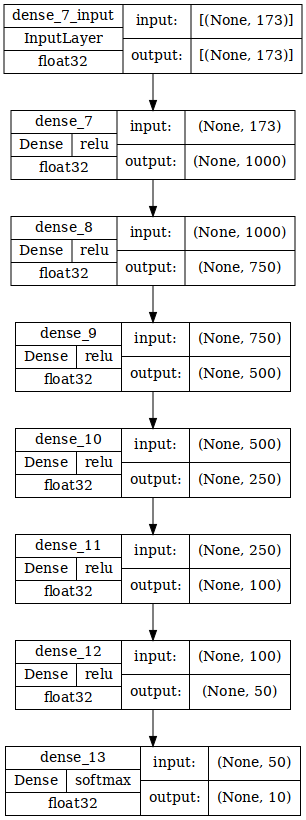

In [10]:
# Model definition
model_ann = keras.models.Sequential(name="ANN", layers=[
    keras.layers.Dense(1000, activation="relu", input_shape=(x_train.shape[1],)),
    keras.layers.Dense(750, activation="relu"),
    keras.layers.Dense(500, activation="relu"),
    keras.layers.Dense(250, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dense(len(CLASSES), activation="softmax")
])

# Model summary and plot
model_ann.summary()
keras.utils.plot_model(
    model_ann,
    show_shapes=True, show_dtype=True, show_layer_names=True, show_layer_activations=True,
    rankdir="TB", dpi=72,
    to_file=(TEMP_FOLDER / "model_plot_ann.png")
)

### C.3 - Model optimizer and loss function
We use the [ADAM](https://keras.io/api/optimizers/adam/) optimizer because it has very good performance, often better the more iterations the model has. The loss function used is the [categorical crossentropy](https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-class) because it is a multi-class classification model.

In [11]:
adam_optimizer = keras.optimizers.Adam(learning_rate=0.001)
model_ann.compile(loss="categorical_crossentropy", optimizer=adam_optimizer, metrics=["accuracy"])

### C.4 - Model callbacks
A callback is an object that can perform actions at various stages of training. We use the [ModelCheckpoint](https://keras.io/api/callbacks/model_checkpoint/) to regularly save our model to the disk.

In [12]:
# Model checkpoint to save the model to the disk
ckpt_name_base = "1_model-ann-ckpt"

checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=str(MODELS_FOLDER / f"{ckpt_name_base}_e-{{epoch:02d}}_vloss-{{val_loss:.2f}}.hdf5"),
    monitor="val_loss",
    save_best_only=True,
    verbose=0
)

### C.5 - Model training

In [13]:
batch_size = 128
epochs = 200

start_time = timer()
training_ann = model_ann.fit(x=x_train, y=y_train, validation_split=0.080, batch_size=batch_size, epochs=epochs, callbacks=[checkpoint_callback], verbose=1)
print(f"The training of the \"{model_ann.name}\" model took {timedelta(seconds=(timer() - start_time))}.")

Epoch 1/200


2023-02-16 11:30:20.118240: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x1a964aa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-02-16 11:30:20.118292: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce GTX 1080, Compute Capability 6.1
2023-02-16 11:30:20.348323: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-02-16 11:30:20.850148: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-02-16 11:30:20.963994: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


51/51 [==============================] - 6s 18ms/step - loss: 2.1187 - accuracy: 0.2095 - val_loss: 2.0021 - val_accuracy: 0.2898
Epoch 2/200
51/51 [==============================] - 1s 13ms/step - loss: 1.9113 - accuracy: 0.2859 - val_loss: 1.8277 - val_accuracy: 0.2987
Epoch 3/200
51/51 [==============================] - 1s 12ms/step - loss: 1.7800 - accuracy: 0.3266 - val_loss: 1.7776 - val_accuracy: 0.3041
Epoch 4/200
51/51 [==============================] - 1s 11ms/step - loss: 1.7252 - accuracy: 0.3430 - val_loss: 1.8237 - val_accuracy: 0.3345
Epoch 5/200
51/51 [==============================] - 1s 11ms/step - loss: 1.6783 - accuracy: 0.3701 - val_loss: 1.7891 - val_accuracy: 0.3399
Epoch 6/200
51/51 [==============================] - 1s 13ms/step - loss: 1.6290 - accuracy: 0.3858 - val_loss: 1.7053 - val_accuracy: 0.3542
Epoch 7/200
51/51 [==============================] - 1s 11ms/step - loss: 1.5633 - accuracy: 0.4194 - val_loss: 1.9302 - val_accuracy: 0.2701
Epoch 8/200
51/51 

### C.6 - Saving the history
We save the training history for a later use.

In [20]:
history_ann = pandas.DataFrame(training_ann.history)
history_ann.to_csv(MODELS_FOLDER / "histories" / "1_model-ann_16-02-23_11-37.csv")

### C.7 - Loading the best model
We load the checkpoint with the lowest validation loss. This model may not be the most accurate, but it is not over-fitted for its dataset.

In [14]:
best_model = helpers.ckpts.load_best_model(models_folder=MODELS_FOLDER, base_name=ckpt_name_base)

## D - Evaluating the model
### D.1 - Accuracy and loss
Accuracy is a measure of the quality of the model predictions. The model predictions are compared to the true values in the dataset.

The loss is a value that represents the sum of the errors of our model. It measures the efficiency of our model. If the errors are large, the loss will be high, which means that the model is not doing a good job. The lower it is, the better our model works.

A high loss means that there are large errors in the model predictions, a low accuracy means that there are many errors.

In [15]:
helpers.perfs.print_model_metrics(model=best_model, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)

Model metrics (ANN):
Training > loss=1.481 | accuracy=45.812
Testing > loss=1.687 | accuracy=37.607


The best model was selected based on the value of the loss. This means that no other ANN model, more or less trained, was better than this one.

The loss value between the training and test sets is almost the same. But the low accuracy score on the training set and the test set implies that our model is under-fitted to the data set. The model cannot learn from the input data.

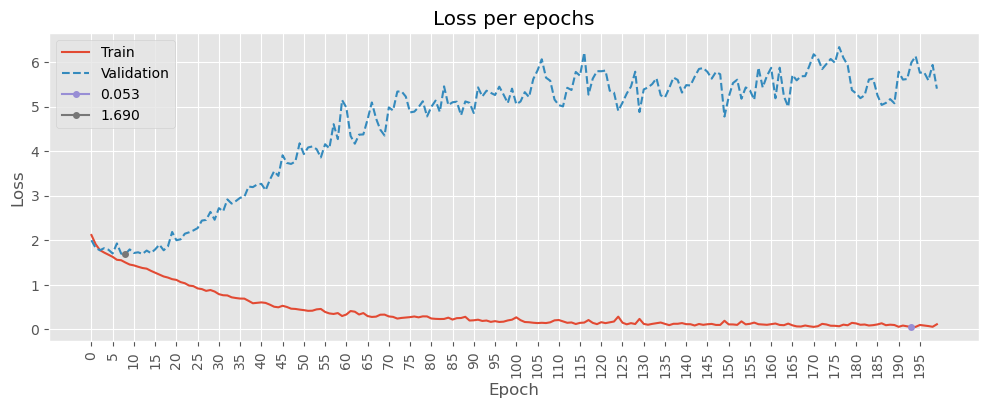

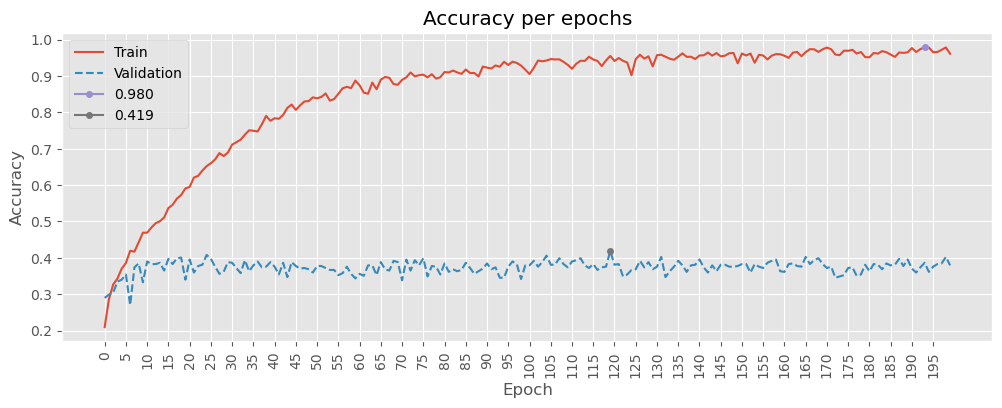

In [16]:
helpers.perfs.plot_loss_curve(history=training_ann.history)
helpers.perfs.plot_accuracy_curve(history=training_ann.history)

We can see with the following graphs that the model tends to over-fit very quickly, around the 12th epoch.

### D.2 - Confusion matrix

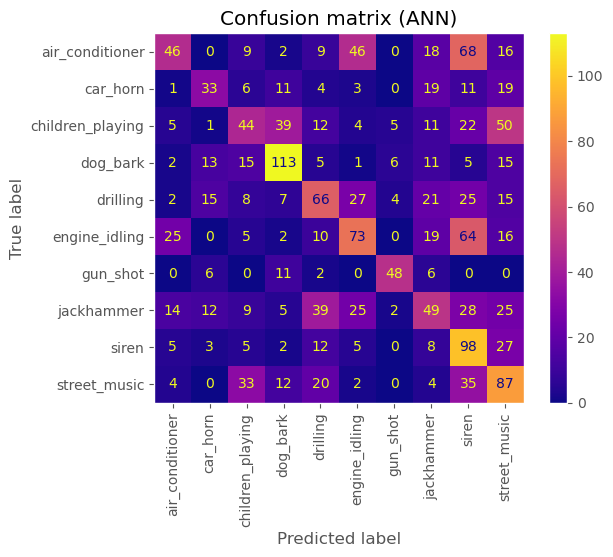

              Class Accuracy
0   air_conditioner   21.5 %
1          car_horn  30.84 %
2  children_playing   22.8 %
3          dog_bark  60.75 %
4          drilling  34.74 %
5     engine_idling  34.11 %
6          gun_shot  65.75 %
7        jackhammer  23.56 %
8             siren  59.39 %
9      street_music  44.16 %


In [17]:
helpers.perfs.plot_confusion_matrix(model=best_model, x_test=x_test, y_test=y_test, le=label_encoder, classes=CLASSES)

The confusion matrix makes it easier to visualize the errors in our model. We can see huge prediction errors between some classes such as `air_conditioner` with `engine_idling` and `children_playing` with `street_music`.

### D.3 - Classification report

In [18]:
helpers.perfs.print_classification_report(model=best_model, x_test=x_test, y_test=y_test, le=label_encoder, classes=CLASSES)

Classification report (ANN):
                  precision    recall  f1-score   support

 air_conditioner       0.44      0.21      0.29       214
        car_horn       0.40      0.31      0.35       107
children_playing       0.33      0.23      0.27       193
        dog_bark       0.55      0.61      0.58       186
        drilling       0.37      0.35      0.36       190
   engine_idling       0.39      0.34      0.36       214
        gun_shot       0.74      0.66      0.70        73
      jackhammer       0.30      0.24      0.26       208
           siren       0.28      0.59      0.38       165
    street_music       0.32      0.44      0.37       197

        accuracy                           0.38      1747
       macro avg       0.41      0.40      0.39      1747
    weighted avg       0.39      0.38      0.37      1747



As expected, the class `air conditioner` gets the worst recall score. We saw earlier on the confusion matrix that this class is largely confused with the class `engine_idling`. We could have thought that the `car_horn` class has the worst recall score because this class is less represented. But the class `gun_shot` has almost the same volume of data as `car_horn` and its recall score is two times better.

## E - Conclusion of the ANN model
The performance graphs showed us that this Artificial Neural Network model gets a terribly low classification score. This is mainly due to the fact that a densely-connected model takes a two-dimensional array as input with $(batchSize,inputDim)$. The input data must therefore be a one-directional array, which forces us to average the Mel spectrogram. Averaging results in a loss of data, thus a loss of score.

In the next notebook, we will perform almost the same experiment but this time using a CNN model.